In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.io import mmread
import os
import scipy
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

: 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scMVP.dataset import LoadData,GeneExpressionDataset, CellMeasurement
from scMVP.models import VAE_Attention, Multi_VAE_Attention, VAE_Peak_SelfAttention
from scipy.optimize import linear_sum_assignment as linear_assignment


from scMVP.inference import UnsupervisedTrainer
from scMVP.inference import MultiPosterior, MultiTrainer

import torch

import scanpy as sc
import anndata

import scipy.io as sp_io
from scipy.sparse import csr_matrix, issparse

[2022-10-11 22:32:22,995] INFO - scMVP._settings | Added StreamHandler with custom formatter to 'scMVP' logger.
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [3]:
import torch
print(torch.__version__)

1.11.0


In [4]:
input_path = "./E18_mouse_Brain/"
output_path = "./E18_mouse_Brain/scMVP_output/"
n_epochs_all = None
show_plot = True
test_mode = False

Input_dataset = {
                "gene_names": 'RNA/genes.tsv',
                "gene_expression": 'RNA/matrix.mtx',
                "gene_barcodes": 'RNA/barcodes.tsv',
                "atac_names": 'ATACTFIDF/genes.tsv',
                "atac_expression":'ATACTFIDF/matrix.mtx',
                "atac_barcodes": 'ATACTFIDF/barcodes.tsv'
                }

dataset = LoadData(dataset=Input_dataset,data_path=input_path,
                       dense=False,gzipped=False, atac_threshold=0.001,
                       cell_threshold=1)

[2022-10-11 22:32:23,684] INFO - scMVP.dataset.scMVP_dataloader | Preprocessing joint profiling dataset.
[2022-10-11 22:33:55,051] INFO - scMVP.dataset.scMVP_dataloader | Finished preprocessing dataset
[2022-10-11 22:33:55,536] INFO - scMVP.dataset.dataset | Remapping labels to [0,N]
[2022-10-11 22:33:55,537] INFO - scMVP.dataset.dataset | Remapping batch_indices to [0,N]
[2022-10-11 22:33:57,583] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2022-10-11 22:33:57,711] INFO - scMVP.dataset.dataset | Downsampled from 3365 to 3365 cells


In [5]:
dataset.filter_cells_by_count()

[2022-10-11 22:33:59,899] INFO - scMVP.dataset.dataset | Computing the library size for the new data
[2022-10-11 22:34:00,031] INFO - scMVP.dataset.dataset | Downsampled from 3365 to 3365 cells


In [6]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 3365 x 32285
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_vars', 'barcodes', 'local_means', 'batch_indices', 'atac_expression', 'labels'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_columns: {'atac_expression': 'atac_names'}

In [1]:
# atac_dataset = GeneExpressionDataset()
# cell_attributes_dict = {
#     "barcodes": dataset.barcodes
#     }
# atac_dataset.populate_from_data(
#     X=dataset.atac_expression, # notice the normalization
#     batch_indices=None,
#     gene_names=dataset.atac_names,
#     cell_attributes_dict=cell_attributes_dict,
#     Ys=[],
# )
# rna_dataset = GeneExpressionDataset()
# Ys = []
# measurement = CellMeasurement(
#         name="atac_expression",
#         data=atac_dataset.X,
#         columns_attr_name="atac_names",
#         columns=atac_dataset.gene_names,
#     )
# Ys.append(measurement)
# cell_attributes_dict = {
#     "barcodes": dataset.barcodes
#     }
# rna_dataset.populate_from_data(
#     X=dataset.X,
#     batch_indices=None,
#     gene_names=dataset.gene_names,
#     cell_attributes_dict=cell_attributes_dict,
#     Ys=Ys,
# )

In [7]:
output_path = "./E18_mouse_Brain/scMVP_output/"
lr = 5e-3
use_batches = False
use_cuda = True
n_alfa = 1.0
n_centroids=10

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0,n_latent=30, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.exists('%s/multi_vae_trainer.pkl' % output_path):
    trainer.model.load_state_dict (torch.load('%s/multi_vae_trainer.pkl' % output_path))
else:
    trainer.train(n_epochs=50, lr=lr)
    os.mkdir(output_path)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)

trainer.model.eval()

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

In [9]:
np.shape(dataset.X)

(3365, 32285)

In [31]:
np.save('./E18_mouse_Brain/SCMVP_atac.npy', latent_atac)
np.save('./E18_mouse_Brain/SCMVP_rna.npy', latent_rna)

In [8]:
import numpy as np
import tkinter
import matplotlib
import matplotlib.pyplot as plt
plt.style.use(['science','nature'])
from matplotlib.lines import Line2D  # for legend handle

# import met_brewer
plt.rcParams['figure.dpi'] = 150

from numpy.linalg import inv
import pandas as pd

In [2]:
latent_atac = np.load('./E18_mouse_Brain/SCMVP_atac.npy')
latent_rna = np.load('./E18_mouse_Brain/z_rna.npy')

In [3]:
import pandas as pd
df_meta= pd.read_csv("E18_mouse_Brain/RNA/metadata.tsv",sep = "\t",index_col=0)

In [4]:
X = latent_atac
Y = latent_rna
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)

In [5]:
colors = ['#2f357c', '#b0799a', '#e69b00', '#355828', '#6c5d9e', '#bf3729', '#e48171']
cell_type = ['Deeper Layer', 'Ependymal cells', 'IPC', 'RG, Astro, OPC','Subplate', 
             'Upper Layer', 'V-SVZ']
colors = dict(zip(cell_type, colors))

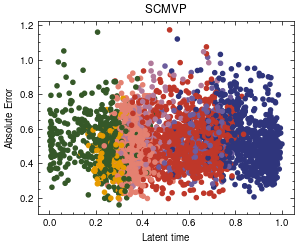

In [6]:
%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))
# handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
# plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('SCMVP')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')
plt.show()

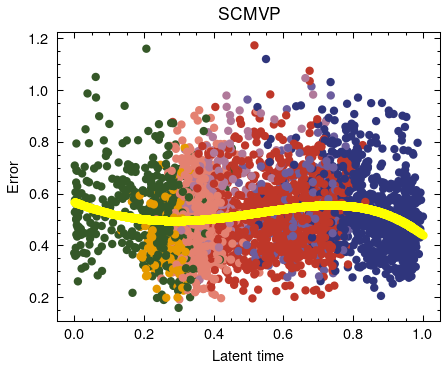

In [9]:
%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))

z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')


# handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
# plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('SCMVP')
plt.xlabel('Latent time')
plt.ylabel('Error')

plt.show()

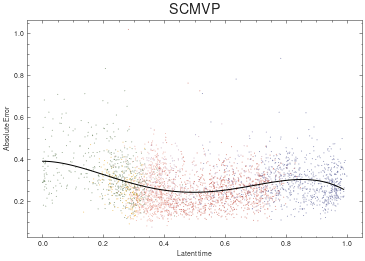

In [25]:
z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)

plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors),s=0.03,alpha = 1)
Times = np.arange(0.0, 1.0, 0.01)
plt.plot(Times, p(Times),color='black')

# handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
# plt.legend(title='Cell Type', handles=handles, bbox_to_anchor=(1, 1), loc='best')



plt.title('SCMVP')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

In [77]:
X = latent_atac
Y = dataset.X
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual = np.mean(np.abs(Y_Residual),axis=1)

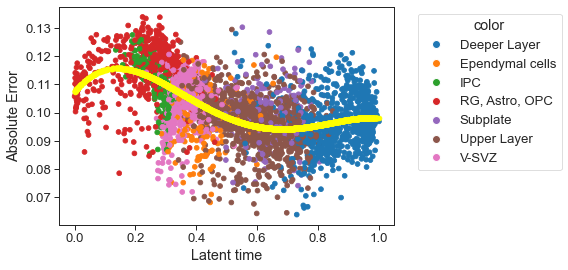

In [82]:
import tkinter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend handle


colors = {'Deeper Layer':'tab:blue', 'Ependymal cells':'tab:orange', 'IPC':'tab:green', 'RG, Astro, OPC':'tab:red', 
          'Subplate':'tab:purple', 'Upper Layer':'tab:brown', 'V-SVZ':'tab:pink'}

%matplotlib inline
plt.scatter(df_meta['latent_time'], Y_Residual, color=df_meta['celltype'].map(colors))


z = np.polyfit(df_meta['latent_time'], Y_Residual, 4)
p = np.poly1d(z)
plt.scatter(df_meta['latent_time'], p(df_meta['latent_time']),color='yellow')



handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(title='color', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.title('My title')
plt.xlabel('Latent time')
plt.ylabel('Absolute Error')

plt.show()

In [10]:
# output_path = "./BM/scMVP_output_V2/"
# lr = 5e-3
# use_batches = False
# use_cuda = True
# n_alfa = 1.0
# n_centroids=15

# # joint RNA and ATAC embedding
# multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0,n_latent=30, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
# trainer = MultiTrainer(
#     multi_vae,
#     dataset,
#     train_size=0.9,
#     use_cuda=use_cuda,
#     frequency=5,
# )

# if os.path.exists('%s/multi_vae_trainer.pkl' % output_path):
#     trainer.model.load_state_dict (torch.load('%s/multi_vae_trainer.pkl' % output_path))
# else:
#     trainer.train(n_epochs=50, lr=lr)
#     os.mkdir(output_path)
#     torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer.pkl' % output_path)

# trainer.model.eval()

# full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
# latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
# batch_indices = batch_indices.ravel()
# imputed_values = full.sequential().imputation()

In [9]:
output_path = "./BM/scMVP_output_V3/"
lr = 5e-3
use_batches = False
use_cuda = True
n_alfa = 1.0
n_centroids=11

# joint RNA and ATAC embedding
multi_vae = Multi_VAE_Attention(dataset.nb_genes, len(dataset.atac_names), n_batch=0,n_latent=30, n_centroids=n_centroids, n_alfa = n_alfa, mode="mm-vae") # should provide ATAC num, alfa, mode and loss type
trainer = MultiTrainer(
    multi_vae,
    dataset,
    train_size=0.9,
    use_cuda=use_cuda,
    frequency=5,
)

if os.path.exists('%s/multi_vae_trainer_centroid_11_100epoch.pkl' % output_path):
    trainer.model.load_state_dict (torch.load('%s/multi_vae_trainer_centroid_11_100epoch.pkl' % output_path,
                                              map_location=torch.device('cpu')))
else:
    trainer.train(n_epochs=100, lr=lr)
#     os.mkdir(output_path)
    torch.save(trainer.model.state_dict(), '%s/multi_vae_trainer_centroid_11_100epoch.pkl' % output_path)

trainer.model.eval()

full = trainer.create_posterior(trainer.model, dataset, indices=np.arange(len(dataset)),type_class=MultiPosterior)
latent, latent_rna, latent_atac, cluster_gamma, cluster_index, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()
imputed_values = full.sequential().imputation()

In [46]:
rna_ad = sc.read('BM/bm_multiome_rna.h5ad')
atac_ad = sc.read('BM/bm_multiome_atac.h5ad')
adata = sc.read('BM/bm_multiome_rna.h5ad')

In [47]:
rna_metacell = rna_ad.obs['SEACell']
atac_metacell = atac_ad.obs['SEACell']

In [62]:
rna_ad = sc.read('E18_mouse_Brain/RNA_P.h5ad')

In [63]:
rna_ad

AnnData object with n_obs × n_vars = 3365 × 32285
    obs: 'n_counts', 'celltype'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

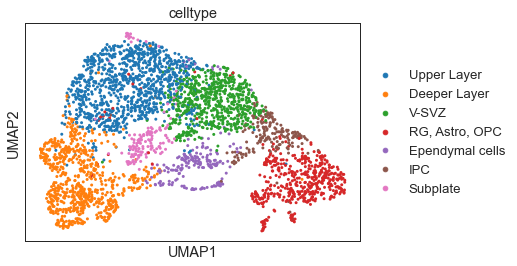

In [65]:
rna_ad.obsm["X_multi_vi"] = latent
sc.pp.neighbors(rna_ad, use_rep="X_multi_vi", n_neighbors=15)

sc.tl.umap(rna_ad)
sc.tl.louvain(rna_ad)

%matplotlib inline
sc.pl.umap(rna_ad, color=['celltype'])
plt.show()

In [22]:
## test on VAE
adata.obsm["X_multi_vi"] = latent
n_SEACells = 100
build_kernel_on = 'X_multi_vi'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="linear", method="spectral")
model.fit(n_iter=20)
scmvp_metacell = adata.obs['SEACell']

initialize SeaCells
apply the spectral
Building kernel...


initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : linear
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing linear kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_multi_vi
Computing diffusion components from X_multi_vi for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 83 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/27 [00:00<?, ?it/s]

Selecting 17 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.0034515002033639647
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


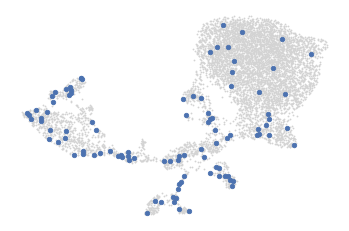

In [44]:
n_SEACells = 100
build_kernel_on = 'X_multi_vi'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="linear")

# np.random.seed(1111)
model.initialize_archetypes()
SEACells.plot.plot_initialization(adata, model)
model.fit(n_iter=20)
scmvp_metacell = adata.obs['SEACell']

In [45]:
rna_ad.obs['SEACell'] = scmvp_metacell
atac_ad.obs['SEACell'] = scmvp_metacell


SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))


compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.939397
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    1.432761
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.766265
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    1.568912
dtype: float64
Determing nearest neighbor graph...
separation    0.664338
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [ ]:
rna_metacell = rna_ad.obs['SEACell']
atac_metacell = atac_ad.obs['SEACell']

In [50]:
rna_ad

AnnData object with n_obs × n_vars = 7439 × 17226
    obs: 'sample', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'batch', 'DoubletScores', 'n_counts', 'leiden', 'log_n_counts', 'celltype', 'SEACell'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'leiden', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'MAGIC_imputed_data', 'X_FDL', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : rbf
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing rbf kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 81 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/29 [00:00<?, ?it/s]

Selecting 19 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.024360783516470513
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


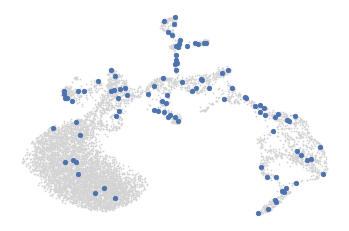

In [56]:
n_SEACells = 100
build_kernel_on = 'X_pca'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(rna_ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="rbf")

# np.random.seed(1111)
model.initialize_archetypes()
SEACells.plot.plot_initialization(rna_ad, model)
model.fit(n_iter=20)
rna_metacell = rna_ad.obs['SEACell']

In [59]:
atac_ad

AnnData object with n_obs × n_vars = 7439 × 219242
    obs: 'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'celltype', 'sample', 'SEACell'
    var: 'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx'
    uns: 'ArchRGeneScoresColumns', 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'sample_colors', 'umap'
    obsm: 'ArchRGeneScores', 'X_ArchR_umap', 'X_FDL', 'X_svd', 'X_umap'
    obsp: 'connectivities', 'distances'

initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : rbf
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing rbf kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


Done.
Sampling waypoints ...
Done.
Selecting 84 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/26 [00:00<?, ?it/s]

Selecting 16 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.0020513322018363513
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


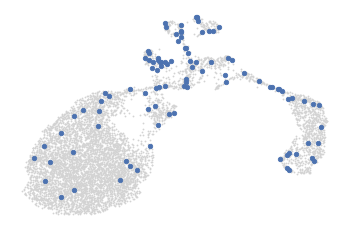

In [69]:
n_SEACells = 100
build_kernel_on = 'X_svd'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(atac_ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="rbf")

# np.random.seed(1111)
model.initialize_archetypes()
SEACells.plot.plot_initialization(atac_ad, model)
model.fit(n_iter=20)
atac_metacell = atac_ad.obs['SEACell']

In [70]:
rna_ad.obs['SEACell'] = atac_metacell
atac_ad.obs['SEACell'] = atac_metacell


SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))


compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.905119
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    0.79866
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.720622
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.562073
dtype: float64
Determing nearest neighbor graph...
separation    0.706028
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [20]:
max_atac_sep = 0
while max_atac_sep<0.70:
    n_SEACells = 100
    build_kernel_on = 'X_multi_vi'
    n_waypoint_eigs = 10 
    waypoint_proportion = 0.9 
    model = SEACells.core.SEACells(adata, 
                      build_kernel_on=build_kernel_on, 
                      n_SEACells=n_SEACells, 
                      n_waypoint_eigs=n_waypoint_eigs,
                      waypt_proportion=waypoint_proportion,
                      convergence_epsilon = 1e-5,
                      kernel="linear", method="spectral")
    model.fit(n_iter=20)
    scmvp_metacell = adata.obs['SEACell']
    
    atac_ad.obs['SEACell'] = scmvp_metacell
    
    separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
    mean_separation = np.mean(separation).separation
    if mean_separation > max_atac_sep:
        max_atac_sep = mean_separation
        print(max_atac_sep)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0.6832867157996161
initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


0.6939578569192222
initialize SeaCells
apply the spectral
Building kernel...
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


0.7236657010254831


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [188]:
rna_metacell.to_csv('BM/RNA_metacell.csv')
atac_metacell.to_csv('BM/ATAC_metacell.csv')
scmvp_metacell.to_csv('BM/scmvp_metacell.csv')

# Gene-peak correlations


In [10]:
rna_ad = sc.read('BM/bm_multiome_rna.h5ad')
atac_ad = sc.read('BM/bm_multiome_atac.h5ad')
adata = sc.read('BM/bm_multiome_rna.h5ad')

In [12]:
scmvp_metacell =pd.read_csv('BM/scmvp_metacell.csv',index_col=0)
rna_metacell = rna_ad.obs['SEACell']
atac_metacell = atac_ad.obs['SEACell']

In [13]:
rna_ad.obs['SEACell'] = scmvp_metacell['SEACell'].astype('str')
atac_ad.obs['SEACell'] = scmvp_metacell['SEACell'].astype('str')
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell')

Generating Metacell matrices...
 ATAC


100%|███████████████████████████████████████████| 86/86 [00:04<00:00, 19.44it/s]
/Users/mij51/Desktop/hackthon/SEACells_2/SEACells/genescores.py:59: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac_meta_ad = sc.AnnData(summ_matrix)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


 RNA


100%|██████████████████████████████████████████| 86/86 [00:00<00:00, 223.25it/s]
/Users/mij51/Desktop/hackthon/SEACells_2/SEACells/genescores.py:80: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  rna_meta_ad = sc.AnnData(summ_matrix)


In [ ]:
gene_set = rna_meta_ad.var_names
# gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
#                                            path_to_gtf='./hg38.gtf', 
#                                            span=100000, 
#                                            n_jobs=1,
#                                            gene_set=gene_set)

# gene_peak_cors.to_pickle("cd34/cd34_multiome_gene_peak_cors_SCMVP.pkl")  

gene_peak_cors = pd.read_pickle("cd34/cd34_multiome_gene_peak_cors_SCMVP.pkl") 
gene_peak_cors_SCMVP = pd.read_pickle("BM/BM_multiome_gene_peak_cors_SCMVP.pkl") 


peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors, 
                                                           pval_cutoff=1e-1,
                                                           cor_cutoff=0.1)

gene_scores = SEACells.genescores.get_gene_scores(atac_meta_ad, 
                                                  gene_peak_cors,
                                                  pval_cutoff=1e-1,
                                                  cor_cutoff=0.1)

peak_counts.to_pickle("cd34/cd34_multiome_peak_counts_SCMVP.pkl") 
gene_scores.to_pickle("cd34/cd34_multiome_gene_scores_SCMVP.pkl") 

In [ ]:
# rna_ad.obs['SEACell'] = rna_metacell
# atac_ad.obs['SEACell'] = rna_metacell
# atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell')

# gene_set = rna_meta_ad.var_names
# gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
#                                            path_to_gtf='./hg38.gtf', 
#                                            span=100000, 
#                                            n_jobs=1,
#                                            gene_set=gene_set)

# peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors, 
#                                                            pval_cutoff=1e-1,
#                                                            cor_cutoff=0.1)

# gene_scores = SEACells.genescores.get_gene_scores(atac_meta_ad, 
#                                                   gene_peak_cors,
#                                                   pval_cutoff=1e-1,
#                                                   cor_cutoff=0.1)

# gene_peak_cors.to_pickle("BM/BM_multiome_gene_peak_cors_RNA.pkl")  
# peak_counts.to_pickle("BM/BM_multiome_peak_counts_RNA.pkl") 
# gene_scores.to_pickle("BM/BM_multiome_gene_scores_RNA.pkl") 

In [ ]:
# rna_ad.obs['SEACell'] = atac_metacell
# atac_ad.obs['SEACell'] = atac_metacell
# atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell')
#
# gene_set = rna_meta_ad.var_names
# gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
#                                            path_to_gtf='./hg38.gtf', 
#                                            span=100000, 
#                                            n_jobs=1,
#                                            gene_set=gene_set)
#
# peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors, 
#                                                            pval_cutoff=1e-1,
#                                                            cor_cutoff=0.1)
#
# gene_scores = SEACells.genescores.get_gene_scores(atac_meta_ad, 
#                                                   gene_peak_cors,
#                                                   pval_cutoff=1e-1,
#                                                   cor_cutoff=0.1)
#
# gene_peak_cors.to_pickle("BM/BM_multiome_gene_peak_cors_ATAC.pkl")  
# peak_counts.to_pickle("BM/BM_multiome_peak_counts_ATAC.pkl") 
# gene_scores.to_pickle("BM/BM_multiome_gene_scores_ATAC.pkl") 



initialize SeaCells
apply the spectral
Building kernel...


/var/folders/yq/wgt5tq6d7q7d6l08jg46y37ntzjz8q/T/ipykernel_44006/4046273656.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scmvp_metacell[cell_idx ] = label


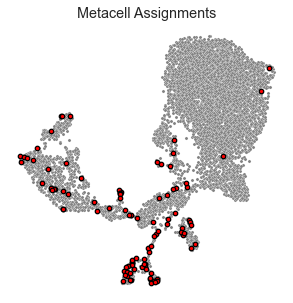

In [22]:
# ## test on VAE
# adata.obsm["X_multi_vi"] = latent
# n_SEACells = 100
# build_kernel_on = 'X_multi_vi'
# n_waypoint_eigs = 10 
# waypoint_proportion = 0.9 
# model = SEACells.core.SEACells(adata, 
#                   build_kernel_on=build_kernel_on, 
#                   n_SEACells=n_SEACells, 
#                   n_waypoint_eigs=n_waypoint_eigs,
#                   waypt_proportion=waypoint_proportion,
#                   convergence_epsilon = 1e-5,
#                   kernel="linear", method="spectral")
# model.fit(n_iter=20)

# scmvp_metacell =adata.obs['SEACell']

# seacell_list = np.unique(scmvp_metacell)
# for i in range(len(seacell_list)):
#     cell_idx =scmvp_metacell == seacell_list[i]
#     label = scmvp_metacell.index[cell_idx].tolist()[0]
#     scmvp_metacell[cell_idx ] = label
    
    
    
# adata.obs['SEACell'] = scmvp_metacell
# SEACells.plot.plot_2D(adata, key='X_umap', colour_metacells=False)

In [56]:
adata_subset = adata[adata.obs.index.isin(np.unique(adata.obs['SEACell']))]

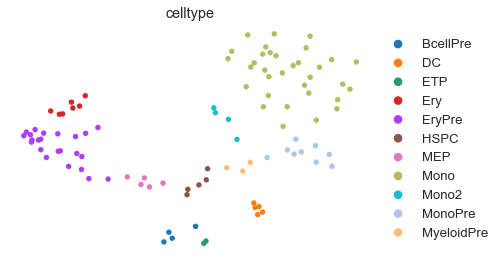

In [110]:
figsize=(5,5),
sc.pl.scatter(adata_subset, basis='umap', color='celltype', frameon=False,size=120000/1000)

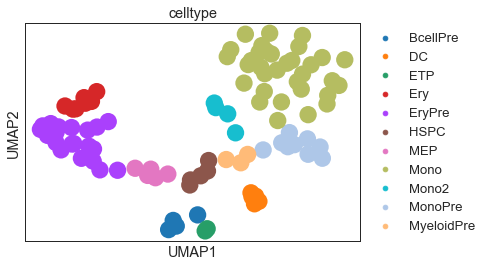

In [33]:
sc.pl.umap(adata_subset, color=['celltype'])

In [8]:
rna_ad.obs['SEACell'] = scmvp_metacell['SEACell'].astype('str')
atac_ad.obs['SEACell'] = scmvp_metacell['SEACell'].astype('str')
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell')

NameError: name 'scmvp_metacell' is not defined

In [102]:
gene_set = rna_meta_ad.var_names
gene_peak_cors = SEACells.genescores.get_gene_peak_correlations(atac_meta_ad, rna_meta_ad, 
                                           path_to_gtf='./hg38.gtf', 
                                           span=100000, 
                                           n_jobs=1,
                                           gene_set=gene_set)

Loading transcripts per gene...
Preparing matrices for gene-peak associations
Computing peak-gene correlations


  0%|                                      | 37/17226 [00:12<1:33:29,  3.06it/s]/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
  0%|                                      | 38/17226 [00:13<1:47:56,  2.65it/s]/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
  6%|██                                   | 973/17226 [04:30<1:48:13,  2.50it/s]/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1919: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)
  6%|██▏                                 | 1029/17226 [04:49<1:42:25,  2.64it/s]/Users/mij51/opt/ana

In [103]:
peak_counts = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors, 
                                                           pval_cutoff=1e-1,
                                                           cor_cutoff=0.1)

gene_scores = SEACells.genescores.get_gene_scores(atac_meta_ad, 
                                                  gene_peak_cors,
                                                  pval_cutoff=1e-1,
                                                  cor_cutoff=0.1)

100%|████████████████████████████████████| 17226/17226 [01:56<00:00, 148.04it/s]


In [133]:
# gene_peak_cors.to_pickle("BM/BM_multiome_gene_peak_cors_SCMVP.pkl")  
# peak_counts.to_pickle("BM/BM_multiome_peak_counts_SCMVP.pkl") 
# gene_scores.to_pickle("BM/BM_multiome_gene_scores_SCMVP.pkl") 

In [160]:
# peak_counts_SCMVP = pd.read_pickle("BM/BM_multiome_peak_counts_SCMVP.pkl") 
# peak_counts_ATAC = pd.read_pickle("BM/BM_multiome_peak_counts_ATAC.pkl") 

gene_peak_cors_SCMVP = pd.read_pickle("BM/BM_multiome_gene_peak_cors_SCMVP.pkl") 
gene_peak_cors_ATAC = pd.read_pickle("BM/BM_multiome_gene_peak_cors_ATAC.pkl") 
# gene_peak_cors_RNA = pd.read_pickle("BM/BM_multiome_gene_peak_cors_RNA.pkl") 

In [211]:
# peak_counts_SCMVP = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors_SCMVP, 
#                                                            pval_cutoff=5e-2,
#                                                            cor_cutoff=0.5)
# peak_counts_ATAC = SEACells.genescores.get_gene_peak_assocations(gene_peak_cors_ATAC, 
#                                                            pval_cutoff=5e-2,
#                                                            cor_cutoff=0.5)

100%|███████████████████████████████████| 17226/17226 [00:03<00:00, 5498.39it/s]


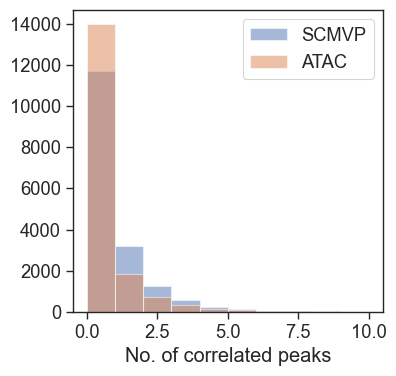

In [213]:
# bins = np.linspace(0, 10, 11)
# plt.hist(peak_counts_SCMVP, bins, alpha=0.5, label='SCMVP')
# plt.hist(peak_counts_ATAC, bins, alpha=0.5, label='ATAC')
# plt.legend(loc='upper right')
# plt.xlabel('No. of correlated peaks')
# plt.show()


In [161]:
ATAC_Cor = []
for i in range(len(gene_peak_cors_ATAC)):
    if type(gene_peak_cors_ATAC[i]) != int:
        ATAC_Cor = np.concatenate((ATAC_Cor, gene_peak_cors_ATAC[i].cor), axis=0) 
        
SCMVP_Cor = []
for i in range(len(gene_peak_cors_SCMVP)):
    if type(gene_peak_cors_SCMVP[i]) != int:
        SCMVP_Cor = np.concatenate((SCMVP_Cor, gene_peak_cors_SCMVP[i].cor), axis=0) 
        
# RNA_Cor = []
# for i in range(len(gene_peak_cors_RNA)):
#     if type(gene_peak_cors_RNA[i]) != int:
#         RNA_Cor = np.concatenate((SCMVP_Cor, gene_peak_cors_RNA[i].cor), axis=0) 

In [162]:
Cor_DF = pd.DataFrame({'SEACells_ATAC':ATAC_Cor,'COEM':SCMVP_Cor})
Cor_DF.SEACells_ATAC[Cor_DF.SEACells_ATAC<0]=0
Cor_DF.COEM[Cor_DF.COEM<0]=0

[Text(0.5, 0, 'metacell method'), Text(0, 0.5, 'peak-gene correlations')]

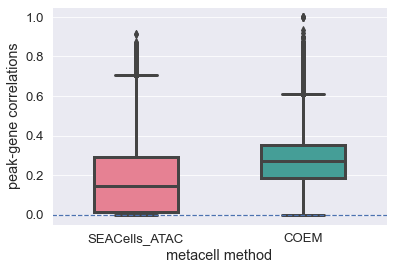

In [163]:
sns.set_style("darkgrid")
ax = sns.boxplot(data=Cor_DF,palette="husl",linewidth=3, width=0.5)
ax.axhline(0, ls='--')
ax.set(xlabel='metacell method', ylabel='peak-gene correlations')

[Text(0.5, 0, 'metacell method'), Text(0, 0.5, 'peak-gene correlations')]

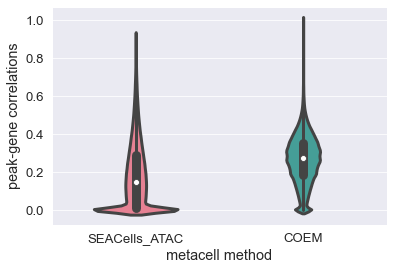

In [164]:
ax = sns.violinplot(data=Cor_DF,palette="husl",linewidth=3, width=0.5)
ax.set(xlabel='metacell method', ylabel='peak-gene correlations')

[Text(0.5, 0, 'metacell method'), Text(0, 0.5, 'peak-gene correlations')]

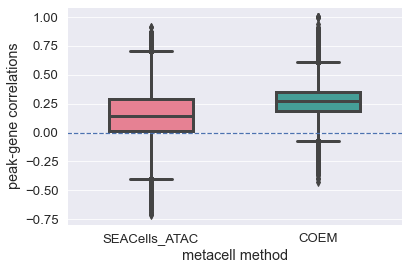

In [165]:
Cor_DF = pd.DataFrame({'SEACells_ATAC':ATAC_Cor,'COEM':SCMVP_Cor})
sns.set_style("darkgrid")
ax = sns.boxplot(data=Cor_DF,palette="husl",linewidth=3, width=0.5)
ax.axhline(0, ls='--')
ax.set(xlabel='metacell method', ylabel='peak-gene correlations')

[Text(0.5, 0, 'metacell method'), Text(0, 0.5, 'peak-gene correlations')]

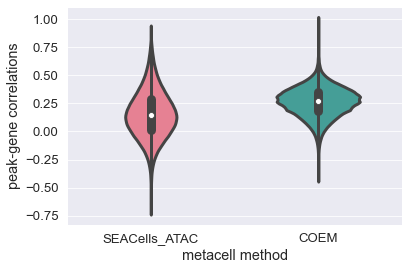

In [166]:
ax = sns.violinplot(data=Cor_DF,palette="husl",linewidth=3, width=0.5)
ax.set(xlabel='metacell method', ylabel='peak-gene correlations')

In [168]:
np.sum(ATAC_Cor<0)/len(ATAC_Cor)

0.22999885471412393

In [169]:
np.sum(SCMVP_Cor<0)/len(SCMVP_Cor)

0.029655632534117703

In [175]:
rna_ad.obs['SEACell'] = rna_metacell
atac_ad.obs['SEACell'] = rna_metacell


SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))


compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.973897
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    0.087303
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.673295
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.319381
dtype: float64
Determing nearest neighbor graph...
separation    0.495155
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [176]:
rna_ad.obs['SEACell'] = atac_metacell
atac_ad.obs['SEACell'] = atac_metacell


SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))


compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.918179
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    1.061353
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.749489
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.8176
dtype: float64
Determing nearest neighbor graph...
separation    0.664937
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [29]:
n_SEACells = 100
build_kernel_on = 'X_multi_vi'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="linear")

initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : linear
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing linear kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...


In [ ]:
# np.random.seed(1111)
model.initialize_archetypes()
SEACells.plot.plot_initialization(adata, model)
model.fit(n_iter=20)

In [31]:
scmvp_metacell = adata.obs['SEACell']

initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : linear
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing linear kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_multi_vi
Computing diffusion components from X_multi_vi for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 82 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/28 [00:00<?, ?it/s]

Selecting 18 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.003553076076926802
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    0.546624
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.674278
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.576732
dtype: float64
Determing nearest neighbor graph...
separation    0.560259
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


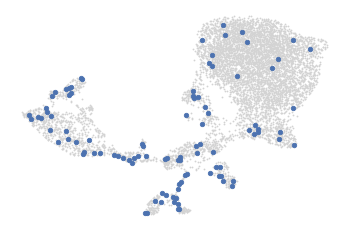

In [34]:
n_SEACells = 100
build_kernel_on = 'X_multi_vi'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="linear")

model.initialize_archetypes()
SEACells.plot.plot_initialization(adata, model)
model.fit(n_iter=20)

scmvp_metacell = adata.obs['SEACell']

rna_ad.obs['SEACell'] = scmvp_metacell
atac_ad.obs['SEACell'] = scmvp_metacell

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
print(np.mean(separation))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
print(np.mean(separation))

initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : rbf
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing rbf kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_multi_vi
Computing diffusion components from X_multi_vi for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 82 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/28 [00:00<?, ?it/s]

Selecting 18 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.003498735002639889
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    0.799174
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.776465
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.81749
dtype: float64
Determing nearest neighbor graph...
separation    0.600877
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


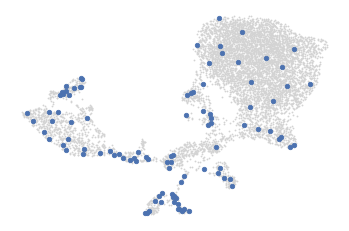

In [37]:
n_SEACells = 100
build_kernel_on = 'X_multi_vi'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="rbf")

model.initialize_archetypes()
SEACells.plot.plot_initialization(adata, model)
model.fit(n_iter=20)

scmvp_metacell = adata.obs['SEACell']

rna_ad.obs['SEACell'] = scmvp_metacell
atac_ad.obs['SEACell'] = scmvp_metacell

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
print(np.mean(separation))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
print(np.mean(separation))

In [21]:
n_SEACells = 100
build_kernel_on = 'X_multi_vi'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(adata, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="rbf")

initialize SeaCells
apply the archetypes
Building kernel...
n_cores -1, kernel : rbf
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing rbf kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...


Building kernel on X_multi_vi
Computing diffusion components from X_multi_vi for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 82 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/28 [00:00<?, ?it/s]

Selecting 18 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.003643908295544635
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


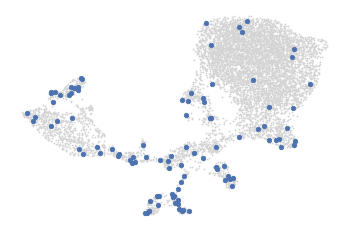

In [22]:
model.initialize_archetypes()
SEACells.plot.plot_initialization(adata, model)
model.fit(n_iter=20)

In [23]:
scmvp_RBF_metacell = adata.obs['SEACell']

In [24]:
rna_ad.obs['SEACell'] = scmvp_RBF_metacell
atac_ad.obs['SEACell'] = scmvp_RBF_metacell


compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    0.628032
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


separation    0.720418
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.563467
dtype: float64
Determing nearest neighbor graph...
separation    0.610527
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


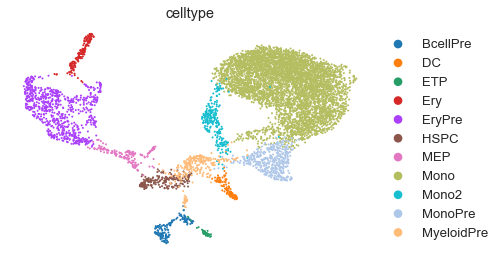

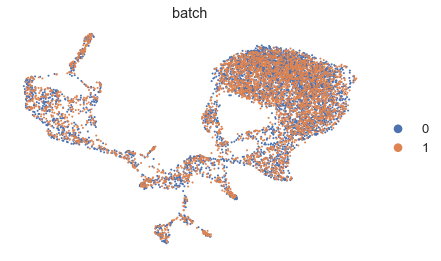

In [23]:
# Normalize cells, log transform and compute highly variable genes
rna_ad.X = rna_ad.raw.X
sc.pp.normalize_per_cell(rna_ad)
sc.pp.log1p(rna_ad)
sc.pp.highly_variable_genes(rna_ad, n_top_genes=3000)
sc.tl.pca(rna_ad, n_comps=50, use_highly_variable=True)
sc.pp.neighbors(rna_ad, n_neighbors=15, n_pcs=30)
sc.tl.umap(rna_ad)
sc.pl.scatter(rna_ad, basis='umap', color='celltype', frameon=False)
sc.pl.scatter(rna_ad, basis='umap', color='batch', frameon=False)

In [24]:
# destination = "BM/rna3000"
# pd.DataFrame(rna_ad.var.index[rna_ad.var['highly_variable']]).to_csv(os.path.join(destination, "genes.tsv" ),   sep = "\t", header = False, index=False)
# pd.DataFrame(rna_ad.obs.index).to_csv(os.path.join(destination, "barcodes.tsv"), sep = "\t", header = False, index=False)
# rna_ad.obs.to_csv(os.path.join(destination, "metadata.tsv"), sep = "\t", header = False, index=False)
# scipy.io.mmwrite(os.path.join(destination, "matrix.mtx"), rna_ad.raw.X[:,rna_ad.var['highly_variable']].transpose())

In [25]:
n_SEACells = 100
build_kernel_on = 'X_pca'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(rna_ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="rbf")

initialize SeaCells
Building kernel...
n_cores -1, kernel : rbf
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing rbf kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...


Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 81 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/29 [00:00<?, ?it/s]

Selecting 19 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.009038120527432145
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


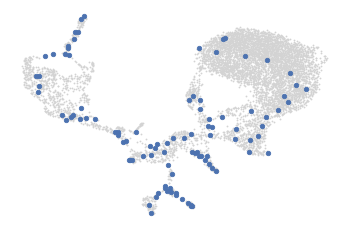

In [26]:
model.initialize_archetypes()
SEACells.plot.plot_initialization(rna_ad, model)
model.fit(n_iter=20)

In [27]:
rna_metacell = rna_ad.obs['SEACell']

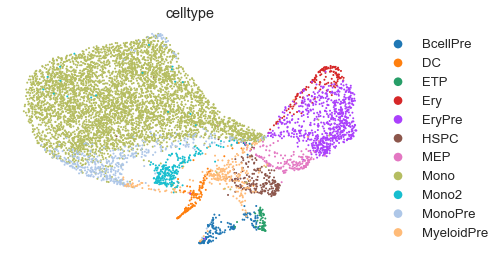

In [28]:
sc.pp.neighbors(atac_ad, n_neighbors=30, n_pcs=30,use_rep='X_svd')
sc.tl.umap(atac_ad)
sc.pl.scatter(atac_ad, basis='umap', color='celltype', frameon=False)

In [29]:
n_SEACells = 100
build_kernel_on = 'X_svd'
n_waypoint_eigs = 10 
waypoint_proportion = 0.9 
model = SEACells.core.SEACells(atac_ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5,
                  kernel="rbf")

initialize SeaCells
Building kernel...
n_cores -1, kernel : rbf
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Making graph symmetric...
Computing rbf kernel...


  0%|          | 0/7439 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/7439 [00:00<?, ?it/s]

Constructing CSR matrix...


Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


Done.
Sampling waypoints ...
Done.
Selecting 81 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/29 [00:00<?, ?it/s]

Selecting 19 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.005719838091084541
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


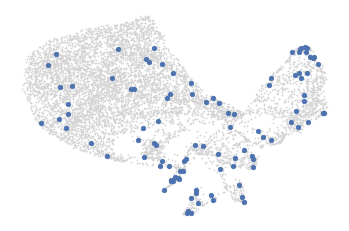

In [30]:
model.initialize_archetypes()
SEACells.plot.plot_initialization(atac_ad, model)
model.fit(n_iter=20)

In [31]:
atac_metacell = atac_ad.obs['SEACell']

In [32]:
rna_ad.obs['SEACell'] = scmvp_RBF_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

atac_ad.obs['SEACell'] = scmvp_RBF_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(atac_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.843189
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    1.175981
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before call

separation    0.625046
dtype: float64
celltype_purity    0.843189
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.124441
dtype: float64
Determing nearest neighbor graph...
separation    0.242857
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [33]:
rna_ad.obs['SEACell'] = scmvp_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

atac_ad.obs['SEACell'] = scmvp_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(atac_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.873188
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    1.561899
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before call

separation    0.63645
dtype: float64
celltype_purity    0.873188
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.128411
dtype: float64
Determing nearest neighbor graph...
separation    0.225337
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [34]:
rna_ad.obs['SEACell'] = rna_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

atac_ad.obs['SEACell'] = rna_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(atac_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.958443
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    0.347466
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before call

separation    0.727635
dtype: float64
celltype_purity    0.958443
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.08126
dtype: float64
Determing nearest neighbor graph...
separation    0.239907
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [35]:
rna_ad.obs['SEACell'] = atac_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(rna_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(rna_ad, 'X_pca')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(rna_ad, 'X_pca',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

atac_ad.obs['SEACell'] = atac_metacell
SEACell_purity = SEACells.evaluate.compute_celltype_purity(atac_ad, 'celltype')
print(np.mean(SEACell_purity))
# print(np.std(SEACell_purity))

compactness = SEACells.evaluate.compactness(atac_ad, 'X_svd')
print(np.mean(compactness))
# print(np.std(compactness))

separation = SEACells.evaluate.separation(atac_ad, 'X_svd',nth_nbr=1)
separation.head()
print(np.mean(separation))
# print(np.std(separation))

/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


celltype_purity    0.894603
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


compactness    1.119347
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before call

separation    0.602285
dtype: float64
celltype_purity    0.894603
dtype: float64
Determing nearest neighbor graph...


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/palantir/utils.py:54: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  temp = sc.AnnData(data_df.values)


compactness    0.022663
dtype: float64
Determing nearest neighbor graph...
separation    0.317881
dtype: float64


/Users/mij51/opt/anaconda3/envs/OceanCells/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
